# Inverting Gradients - ResNet-18 - CIFAR10 - fedAVG

这个笔记本展示了一个小批量图像梯度反演的例子，如论文《反演梯度——在联合学习中破坏隐私有多容易？》中所述。该设置是一个训练好的 ResNet-18，联合学习算法是 fedAVG。

论文链接：[https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html]

这个笔记本可以复现论文中的图 5 和表 2 的实验。

# 摘要

联邦学习的思想是在服务器上协同训练一个神经网络。每个用户接收网络的当前权重，并轮流根据本地数据发送参数更新（梯度）。这种协议不仅旨在高效地训练神经网络，而且还为用户提供隐私保护，因为他们的输入数据保留在设备上，只有参数梯度被共享。但是共享参数梯度有多安全？以前的攻击提供了一种错误的安全感，因为它们只在人为的设置中成功——即使是对于单个图像。然而，通过利用一种与幅度无关的损失函数以及基于对抗攻击的优化策略，我们展示了从参数梯度的知识中忠实地重建高分辨率图像是可能的，并证明了这种隐私的破坏甚至对于训练好的深度网络也是可能的。我们分析了架构和参数对重建输入图像的难度的影响，并证明了任何输入到全连接层的数据都可以独立于剩余架构的分析地重建。最后，我们讨论了实际遇到的设置，并显示即使对多个迭代或多个图像进行梯度平均也不能保护用户在联合学习应用中的隐私。

# 启动

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

# 初始化 cfg 对象和系统设置：

这将加载完整的配置对象。这包括用例和威胁模型的配置作为 cfg.case，以及攻击的超参数和实现作为 cfg.attack。所有参数都可以在下面修改，或者用 overrides= 覆盖，就像它们是命令行参数一样。

In [6]:
cfg = breaching.get_config(overrides=["case=4_fedavg_small_scale", "case/data=CIFAR10"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case fedavg_small_scale with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

# 在这里修改配置选项

您可以使用.attribute访问来修改攻击或情况的任何这些配置:

In [7]:
cfg.case.data.partition="random"
cfg.case.user.user_idx = 1
cfg.case.model='resnet18'

cfg.case.user.provide_labels = True

# These settings govern the total amount of user data and how it is used over multiple local update steps:
cfg.case.user.num_data_points = 4
cfg.case.user.num_local_updates = 4
cfg.case.user.num_data_per_local_update_step = 2


# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 1e-3

# 实例化所有各方

下面几行代码生成“服务器”、“用户”和“攻击者”对象，并打印它们的配置概述。

In [8]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture resnet18 loaded with 11,173,962 parameters and 9,620 buffers.
Overall this is a data ratio of     909:1 for target shape [4, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
    Local FL Setup:
        Number of local update steps: 4
        Data per local update step: 2
        Local learning rate: 0.001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type Optimiza

## 解释

- Model architecture <span class="girk"><span class="girk">resnet18</span></span> loaded with 11,173,962 parameters and 9,620 buffers. 加载了一个resnet18模型，有 11,173,962 个参数和 9,620 个缓冲区。
- Overall this is a data ratio of     909:1 for target shape [4, 3, 32, 32] given that num_queries=1. 给定 num_queries=1 的情况下，目标形状为 [4, 3, 32, 32] 的数据比例为 909:1。目标形状是指要重建的图像的维度，4 代表批量大小，3 代表通道数，32 代表高度和宽度。数据比例是指模型参数和图像像素的比值，越大表示重建难度越高。
---
- User (of type UserMultiStep) with settings: 定义了一个类型为 UserMultiStep 的用户，它有以下的设置：
    - Number of data points: 4 用户拥有的数据点的数量，即图像的数量，为 4。
    - Threat model: 用户在联合学习中的安全假设：
        - User provides labels: True 用户提供了图像的标签，即类别信息，为 True。
        - User provides buffers: False 用户没有提供缓冲区，即模型的中间输出，为 False。
        - User provides number of data points: True 用户提供了数据点的数量，为 True。
    - Data: 用户的数据信息： 
        - Dataset: <span class="girk">CIFAR10</span> 用户的数据集是CIFAR10。
        - user: 1 用户的编号是 1。
    - Local FL Setup: 用户的本地联合学习设置：
        - Number of local update steps: 4 用户在每次通信轮中使用本地数据训练模型的次数为 4。
        - Data per local update step: 2 用户在每次本地更新步中训练的图像数量为 2。
        - Local learning rate: 0.001 用户的本地学习率，即训练模型时的梯度下降的步长，为 0.001。
        - Threat model: 用户的本地威胁模型：
            - Share these hyperparams to server: True 用户是否将这些超参数（本地更新步数，数据量，学习率）分享给服务器，为 True。
---          
- Server (of type HonestServer) with settings: 定义了一个类型为 HonestServer 的服务器：
    - Threat model: Honest-but-curious 服务器的威胁模型，即服务器会按照协议执行联合学习，但是会尝试从用户的梯度中提取信息，为 Honest-but-curious。
    - Number of planned queries: 1 服务器计划的查询次数，即服务器从用户处获取梯度的次数，为 1。
    - Has external/public data: False 服务器是否拥有外部或公开的数据，为 False。
    - Model: 服务器的模型信息：
        - model specification: resnet18 服务器的模型规范，即使用的模型类型，为 resnet18。
        - model state: default 服务器的模型状态，即模型的初始权重，为 default，表示使用随机初始化的权重。
        - public buffers: True 服务器是否公开缓冲区，即模型的中间输出，为 True。
    - Secrets: {} 服务器的秘密信息，即服务器想要从用户的梯度中恢复的图像，为一个空的字典，表示没有指定任何秘密。

---

- Attacker (of type OptimizationBasedAttacker) with settings: 定义了一个类型为 OptimizationBasedAttacker 的攻击者：
    - Hyperparameter Template: invertinggradients 攻击者的超参数模板，即攻击者使用的梯度反演方法，为 invertinggradients，使用基于优化的梯度反演方法。
    - Objective: Cosine Similarity with scale=1.0 and task reg=0.0 攻击者的目标函数，即攻击者使用的重建图像的损失函数，为余弦相似度：
        - scale: 1.0 损失函数的缩放因子，即损失函数的权重，为 1.0。
        - task reg: 0.0 任务正则化的系数，即重建图像的分类准确率的权重，为 0.0，表示不使用任务正则化。
    - Regularizers: Total Variation, scale=0.001. p=1 q=1. 攻击者的正则化项，即攻击者使用的重建图像的平滑性约束，为总变分：
        - scale: 0.001 正则化项的缩放因子，即正则化项的权重，为 0.001。
        - p: 1 正则化项的 p 范数的指数，为 1，表示使用 L1 范数。
        - q: 1 正则化项的 q 范数的指数，为 1，表示使用 L1 范数。
    - Augmentations: 攻击者的数据增强，即攻击者使用的重建图像的变换方式，为空，表示不使用数据增强。
    - Optimization Setup: 攻击者的优化设置，即攻击者使用的重建图像的优化方法：
        - optimizer: adam 攻击者的优化器，即攻击者使用的梯度下降的算法，为 adam 自适应矩估计的方法。
        - signed: hard 攻击者的符号策略，即攻击者使用的梯度的符号处理方式，为 hard，表示使用硬符号，即只保留梯度的符号，忽略梯度的大小。
        - step_size: 0.1 攻击者的步长，即攻击者使用的梯度下降的步长，为 0.1。
        - boxed: True 攻击者的边界约束，即攻击者使用的重建图像的取值范围，为 True，表示使用边界约束，即限制重建图像的像素值在 [0, 1] 之间。
        - max_iterations: 24000 攻击者的最大迭代次数，即攻击者使用的梯度下降的总次数，为 24000。
        - step_size_decay: step-lr 攻击者的步长衰减，即攻击者使用的梯度下降的步长变化方式，为 step-lr，表示使用阶梯式的学习率衰减，即每隔一定的迭代次数，将步长乘以一个衰减因子。
        - langevin_noise: 0.0 攻击者的朗之万噪声，即攻击者使用的梯度下降的随机扰动，为 0.0，表示不使用朗之万噪声。
        - warmup: 0 攻击者的预热步数，即攻击者使用的梯度下降的初始步长增加的次数，为 0，表示不使用预热。
        - grad_clip: None 攻击者的梯度裁剪，即攻击者使用的梯度下降的梯度大小限制，为 None，表示不使用梯度裁剪。
        - callback: 1000 攻击者的回调间隔，即攻击者使用的梯度下降的每隔多少次迭代，输出重建图像的次数，为 1000。

# 模拟被攻击的FL协议


这种交换是对联邦学习协议中单个查询的模拟。服务器发送一个server_payload，用户根据他们的私有本地数据计算更新。这个用户更新是shared_data，例如，在最简单的情况下包含模型的参数梯度。True_user_data也由.compute_local_updates返回，但当然不会转发给服务器或攻击者，而只用于(我们的)分析。

In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


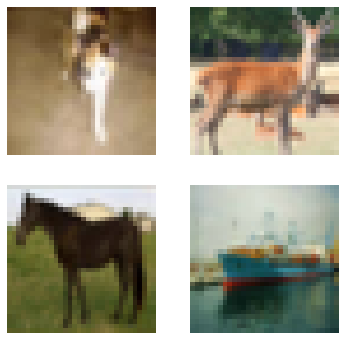

In [10]:
user.plot(true_user_data)

# 重构用户数据:

现在我们开始攻击，仅基于server_payload和shared_data重建用户数据。

您可以提前中断计算以查看部分解决方案。

In [11]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 0.1336 |  Task loss: 2.2506 | T: 0.24s
| It: 1001 | Rec. loss: 0.0362 |  Task loss: 2.2755 | T: 221.97s
| It: 2001 | Rec. loss: 0.0317 |  Task loss: 2.2744 | T: 212.35s
| It: 3001 | Rec. loss: 0.0346 |  Task loss: 2.2587 | T: 209.67s
| It: 4001 | Rec. loss: 0.0349 |  Task loss: 2.2838 | T: 210.98s
| It: 5001 | Rec. loss: 0.0315 |  Task loss: 2.2585 | T: 205.61s
| It: 6001 | Rec. loss: 0.0338 |  Task loss: 2.2741 | T: 211.92s
| It: 7001 | Rec. loss: 0.0331 |  Task loss: 2.2710 | T: 210.64s
| It: 8001 | Rec. loss: 0.0323 |  Task loss: 2.2806 | T: 212.38s
| It: 9001 | Rec. loss: 0.0358 |  Task loss: 2.2718 | T: 208.76s
| It: 10001 | Rec. loss: 0.0270 |  Task loss: 2.3099 | T: 209.42s
| It: 11001 | Rec. loss: 0.0273 |  Task loss: 2.3063 | T: 209.66s
| It: 12001 | Rec. loss: 0.0232 |  Task loss: 2.3138 | T: 209.22s
| It: 13001 | Rec. loss: 0.0241 |  Task loss: 2.3046 | T: 210.11s
| It: 14001 | Rec. loss: 0.0256 |  Task loss: 2.3184 | T: 210.85s
| It: 15001 | Rec. loss: 

接下来我们将评估指标，将reconstructed_user_data与true_user_data进行比较。

In [ ]:
!pip install kornia

In [ ]:
!pip install pytorch_wavelets

In [12]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/root/miniconda3/lib/python3.8/site-packages/breaching/analysis/metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/breaching/analysis/metrics.py:143: UserWarning: To utilize registered PSNR, install kornia.
  warnings.warn("To utilize registered PSNR, install kornia.")


Files already downloaded and verified
METRICS: | MSE: 0.0105 | PSNR: 19.90 | FMSE: 3.6265e-03 | LPIPS: 0.04|
 R-PSNR:  nan | IIP-pixel: 100.00% | SSIM: nan | max R-PSNR:  nan | max SSIM: nan | Label Acc: 100.00%


最后，我们还绘制了重建数据的图像，用于直观地展示重建图像的效果：

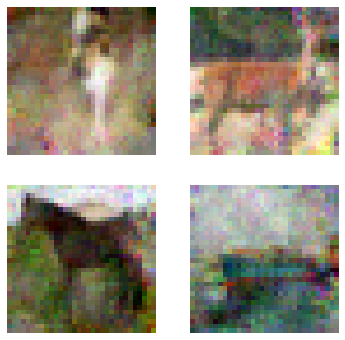

In [13]:
user.plot(reconstructed_user_data)

# 注:

- 如果标签是未知的，那么必须使用一个健壮的标签恢复算法，该算法不计算由于本地更新后的移位而导致的标签重复。